In [1]:
import numpy as np

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import LSBoost
import helper_functions as hf

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)



/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training data size: 2893
Test data size: 724
Max y value: 1
Min y value: 0
Mean train label: 0.417559626685102
Mean test label: 0.4171270718232044
Std train label: 0.4932420097070331
Std test label: 0.49342513114012865


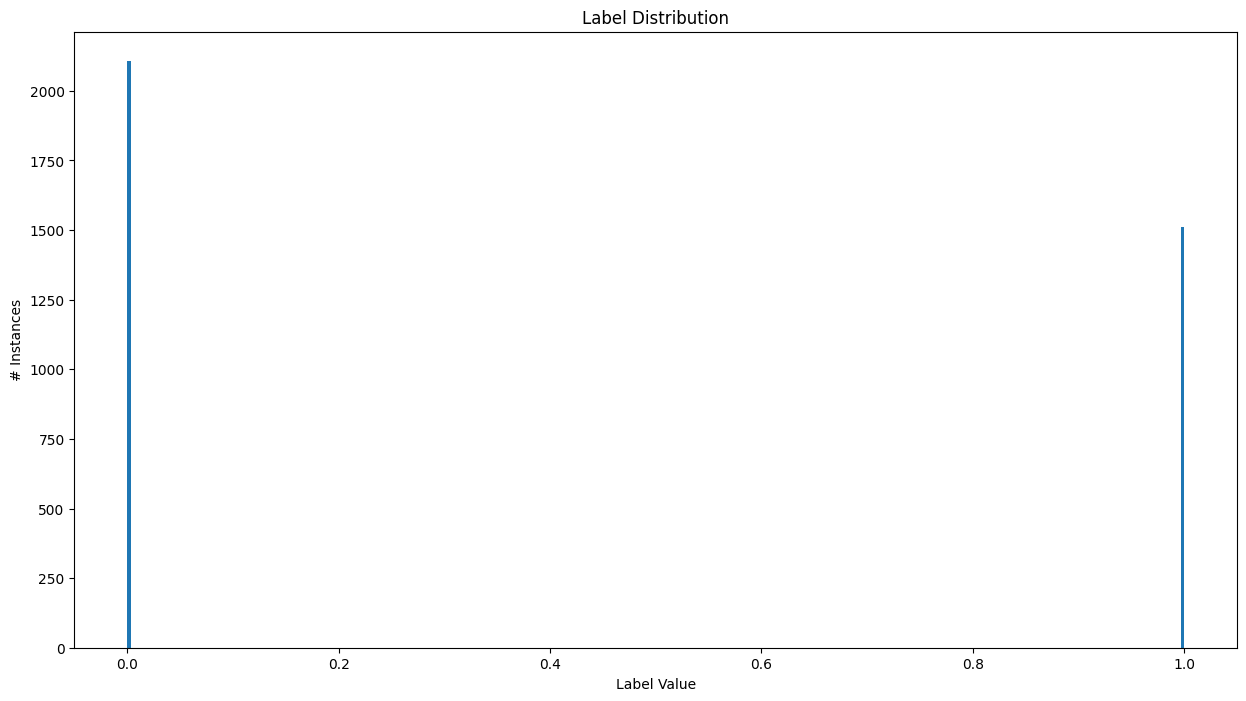

In [2]:
random_state = 42
np.random.seed(random_state)

x_train = pd.read_csv('../data/gib_gbs_clean_inputs_normalized_train.csv')
y_hat_train = x_train['y_hat']
y_train = x_train['y']
x_train = x_train.drop(columns=['y', 'y_hat'])

x_test = pd.read_csv('../data/gib_gbs_clean_inputs_normalized_test.csv')
y_hat_test = x_test['y_hat']
y_test = x_test['y']
x_test = x_test.drop(columns=['y', 'y_hat'])

x_train_no_val, x_val, y_train_no_val, y_val = train_test_split(x_train, y_train, test_size = .2)

hf.print_data_report(x_train, x_test, y_train, y_test)

In [3]:
# number of rounds - (integer)
T = 100

# level sets - (integer)
num_bins = 10

# minimum number of points in level set for update to occur - (integer)
min_group_size = 5

# amount (multiplicative) level set must improve by to accept update if validation data or leniency factor for update requirements - (float)
global_gamma = .005

# weak learner class for UDT - (ML class with .predict method)
weak_learner = DecisionTreeRegressor(max_depth=3)

# determines width of level sets, either 'default' for equal width or 'distribution' for equal number of expected points - (string)
bin_type = 'default'

# multiplicative weight for new update - (float)
learning_rate = 1

# starting model to boost. Set to None for weak learner to be use as initial model - (fit ML class with .predict method or None)
initial_model = None

# round final predictions to level set center or use output of weak learner - (bool)
final_round = True

# center level sets using historical mean - (bool)
center_mean = True


In [4]:
LSBoostRegValidation = LSBoost.LSBoostingRegressor(
                                T = T, 
                                num_bins = num_bins, 
                                min_group_size = min_group_size, 
                                global_gamma = global_gamma, 
                                weak_learner= weak_learner, 
                                bin_type = bin_type, 
                                learning_rate = learning_rate, 
                                initial_model = initial_model,  
                                final_round = final_round, 
                                center_mean=center_mean)
LSBoostRegValidation.fit_validation(x_train_no_val, y_train_no_val, x_val, y_val)

LS:   2%|▏          2/100 00:12, Training Error=0.1389765, Val Error=0.1209537, Lowest Val Error=0.1209537

Early Termination at round: 2
Memory released!


In [5]:
training_predictions = LSBoostRegValidation.predict(x_train)
test_predictions = LSBoostRegValidation.predict(x_test)

np.corrcoef(y_test, test_predictions)

array([[1.       , 0.6392512],
       [0.6392512, 1.       ]])

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import resample
from joblib import Parallel, delayed

def bootstrap_mcc(data, n_bootstraps=500, alpha=0.05, apply_bonferroni=True, num_tests=1):
    def calculate_mcc(data):
        return matthews_corrcoef(*resample(data['y_test'], data['y_hat']))

    mcc_scores = Parallel(n_jobs=-1)(delayed(calculate_mcc)(data) for _ in range(n_bootstraps))

    mcc_scores = np.array(mcc_scores)
    
    if apply_bonferroni:
        alpha /= num_tests
    
    lower_bound = alpha / 2
    upper_bound = 1 - alpha / 2
    
    sorted_scores = np.sort(mcc_scores)
    lower = sorted_scores[int(lower_bound * n_bootstraps)]
    upper = sorted_scores[int(upper_bound * n_bootstraps)]
    mean = np.mean(mcc_scores)
    
    return mean, lower, upper

In [7]:
def plot_cond_mcc(y_hat, pred, y, plot_name = ''):
    np.random.seed(random_state)
    subsets = np.floor(pred * num_bins).astype(int)
    data = pd.DataFrame({
        'y_hat': y_hat,
        'test_predictions': pred,
        'y_test': y,
        'subset_index': subsets
    })

    grouped = data.groupby('subset_index')

    results = {}
    for name, group in grouped:
        median, lower, upper = bootstrap_mcc(group, n_bootstraps=5000, num_tests = len(grouped))
        results[name] = (median, lower, upper)

    mcc_scores = pd.Series({k: v[0] for k, v in results.items()})
    mcc_lower_bounds = pd.Series({k: v[1] for k, v in results.items()})
    mcc_upper_bounds = pd.Series({k: v[2] for k, v in results.items()})
    group_sizes = grouped.size()

    fig, ax = plt.subplots(figsize=(10, 6))

    mcc_df = pd.DataFrame({
        'index': mcc_scores.index,
        'mcc_score': mcc_scores,
        'lower': mcc_lower_bounds,
        'upper': mcc_upper_bounds,
        'size': group_sizes
    })

    mcc_df.to_csv(f'../data/mcc_scores_{plot_name}.csv', index=False) # save figure data to csv

    for _, row in mcc_df.iterrows():
        index, mcc_score, lower, upper, size = row
        ax.scatter(index, mcc_score, s=100, alpha=0.7, color='blue', edgecolor='k', label='_nolegend_')
        ax.plot([index, index], [lower, upper], color='red', linestyle='-', linewidth=2)

    ax.set_xlabel('Level Set Index', fontsize=14, weight='bold')
    ax.set_ylabel("Matthew's Correlation Coefficient", fontsize=14, weight='bold')
    ax.set_title("Conditional MCC (Physician vs Outcome)", fontsize=16, weight='bold')

    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    plt.xticks(list(range(11)))
    plt.tight_layout()
    
    if plot_name != '':
        plt.savefig('../figures/' + plot_name + ".pdf", format="pdf", bbox_inches="tight")
    
    plt.show()

/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was fo

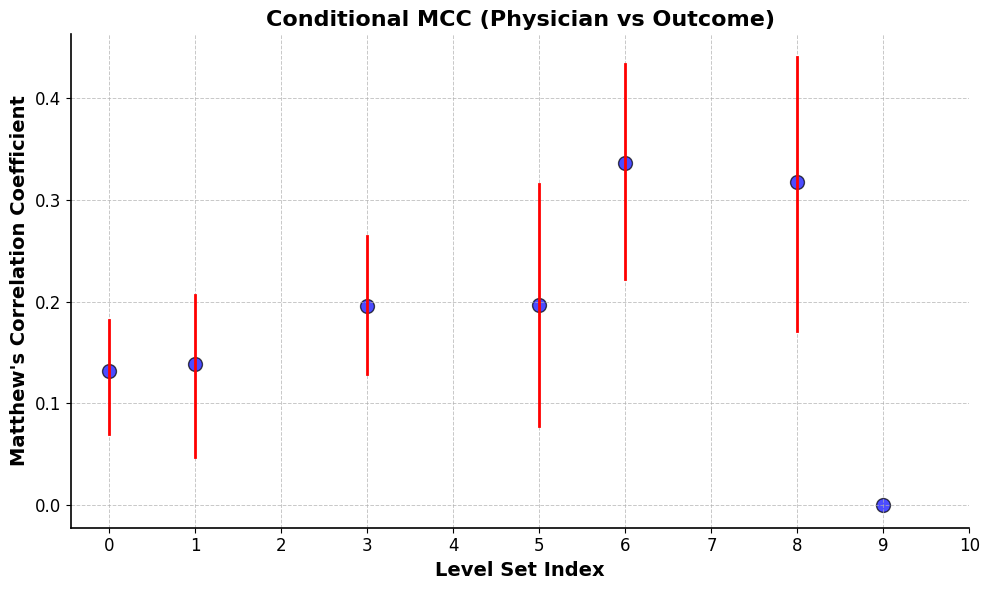

/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was fo

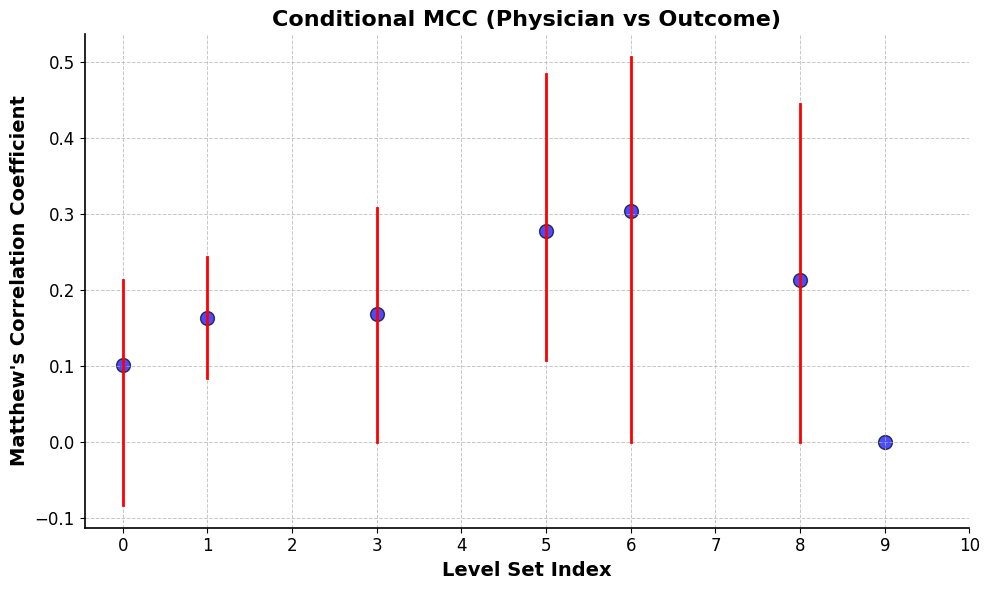

In [8]:
plot_cond_mcc(y_hat_train, training_predictions, y_train, 'mcc_by_pred_train')
plot_cond_mcc(y_hat_test, test_predictions, y_test, 'mcc_by_pred_test')

In [9]:
def eval_policy(policy):
    policy = np.array(policy)
    subsets = np.floor(test_predictions * num_bins).astype(int)
    unique_values, counts = np.unique(subsets, return_counts=True)
    assert(len(unique_values) == len(policy))
    assert(np.all(np.sort(unique_values) == unique_values))

    composite_policy = np.zeros(len(test_predictions))
    for i in range(len(unique_values)):
        val = unique_values[i]
        policy_val = policy[i]
        if policy_val == 0:
            composite_policy[subsets == val] = 0
        elif policy_val == 1:
            composite_policy[subsets == val] = 1
        elif policy_val == 2:
            composite_policy[subsets == val] = y_hat_test[subsets == val]

    tp = np.sum((composite_policy == 1) & (y_test == 1)) / np.sum(y_test == 1)
    fp = np.sum((composite_policy == 1) & (y_test == 0)) / np.sum(y_test == 0)
    pct_automated = np.sum(counts[policy != 2]) / np.sum(counts)

    tp = round(tp, 3)
    fp = round(fp, 3)
    pct_automated = round(pct_automated, 3)

    return tp, fp, pct_automated

In [10]:
from itertools import product

def k_way_cross_product(k):
    s = [0, 1, 2]
    cross_product = list(product(s, repeat=k))
    return cross_product

In [11]:
subsets = np.floor(test_predictions * num_bins).astype(int)
unique_values, counts = np.unique(subsets, return_counts=True)
policies = k_way_cross_product(len(unique_values))

tpr = []
fpr = []
pct_automated = []
for policy in policies:
    tp, fp, pct_auto = eval_policy(policy)
    tpr.append(tp)
    fpr.append(fp)
    pct_automated.append(pct_auto)

In [12]:
df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'pct_automated': pct_automated})

df_filtered = df[df['pct_automated'] > .7]
df_filtered = df_filtered[df_filtered['tpr'] > .95]
df_filtered = df_filtered[df_filtered['fpr'] < .75]

df_filtered = df_filtered.assign(tpr_minus_fpr = df_filtered['tpr'] - df_filtered['fpr']).sort_values('tpr_minus_fpr', ascending=False)

print(df_filtered.head(100))

       tpr    fpr  pct_automated  tpr_minus_fpr
634  0.974  0.519          0.757          0.455
688  0.974  0.524          0.731          0.450
481  0.974  0.526          0.731          0.448
608  0.974  0.533          0.738          0.441
607  0.974  0.533          0.814          0.441
401  0.974  0.536          0.738          0.438
472  0.974  0.536          0.860          0.438
473  0.974  0.536          0.785          0.438
400  0.974  0.536          0.814          0.438
454  0.974  0.540          0.787          0.434
394  0.974  0.540          0.743          0.434
455  0.974  0.540          0.711          0.434
448  0.974  0.545          0.717          0.429
391  0.974  0.545          0.943          0.429
392  0.974  0.545          0.867          0.429
374  0.974  0.550          0.794          0.424
373  0.974  0.550          0.870          0.424
445  0.974  0.550          0.917          0.424
446  0.974  0.550          0.841          0.424
368  0.974  0.555          0.724        

In [13]:
def is_pareto_dominated(row, df):
    weakly_dominated = ((df['tpr'] >= row['tpr']) & (df['fpr'] <= row['fpr']) & (df['pct_automated'] >= row['pct_automated']))
    strictly_dominated = ((df['tpr'] > row['tpr']) | (df['fpr'] < row['fpr']) & (df['pct_automated'] > row['pct_automated']))
    return (weakly_dominated & strictly_dominated).any()

pareto_efficient_rows = df.apply(lambda row: not is_pareto_dominated(row, df), axis=1)
pareto_efficient_df = df[pareto_efficient_rows]


In [14]:
filtered = pareto_efficient_df[pareto_efficient_df['tpr'] >= .97]
filtered = filtered[filtered['fpr'] <= .77]
filtered = filtered[(filtered['pct_automated'] > 0) & (filtered['pct_automated'] < 1)]
filtered


,tpr,fpr,pct_automated
391,0.974,0.545,0.943
392,0.974,0.545,0.867
400,0.974,0.536,0.814
472,0.974,0.536,0.860
607,0.974,0.533,0.814
634,0.974,0.519,0.757
635,0.974,0.519,0.681
643,0.974,0.509,0.627
644,0.974,0.509,0.551
715,0.974,0.509,0.674


In [15]:
print(policies[2185])
print(policies[391])

(2, 2, 2, 2, 2, 2, 1)
(0, 1, 1, 2, 1, 1, 1)


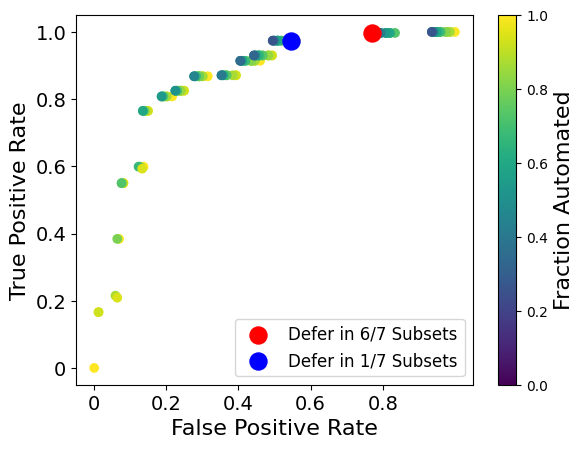

In [16]:
scatter = plt.scatter(pareto_efficient_df['fpr'], pareto_efficient_df['tpr'], c=pareto_efficient_df['pct_automated'])
cbar = plt.colorbar(scatter)
cbar.set_label('Fraction Automated', fontsize=16)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('', fontsize=20)

red_point = plt.scatter(fpr[2185], tpr[2185], c='red', s=150)
blue_point = plt.scatter(fpr[391], tpr[391], c='blue', s=150)

plt.legend([red_point, blue_point], 
           ['Defer in 6/7 Subsets', 'Defer in 1/7 Subsets'], 
           fontsize=12)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8], ['0', '0.2', '0.4', '0.6', '0.8'], fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=14)

plt.savefig('../figures/policies.pdf')

In [17]:
from sklearn.linear_model import LinearRegression


grouping_key = 'mc_predictions'

train_data = x_train.copy()
train_data['y_hat'] = y_hat_train
train_data['mc_predictions'] = training_predictions
train_data['y'] = y_train

grouped = train_data.groupby(grouping_key)

In [18]:
import statsmodels.api as sm

coefficients_list = []
lm_dict = {}
dt_dict = {}
constants_dict = {}

for name, group in grouped:
    if group['y_hat'].var() == 0:
        print(f'Skipping group {name} with variance 0')
    X = sm.add_constant(group[['y_hat']])  # Adds a constant term to the predictor
    y = group['y']
    model = sm.OLS(y, X).fit()
    
    # Extract coefficients and confidence intervals
    coef = model.params['y_hat']
    conf_int = model.conf_int().loc['y_hat']
    
    lm_dict[name] = model
    constants_dict[name] = group['y'].mean()
    
    coefficients_list.append({
        'train_predictions': name,
        'coef': coef,
        'conf_int_lower': conf_int[0],
        'conf_int_upper': conf_int[1],
        'intercept': model.params.get('const', 0),
        'mean_y': group['y'].mean(),
        'mean_y_hat': group['y_hat'].mean(),
    })

# Convert the list to a DataFrame
coefficients = pd.DataFrame(coefficients_list)

print(coefficients)

Skipping group 0.9618320610687023 with variance 0
   train_predictions      coef  conf_int_lower  conf_int_upper     intercept  \
0           0.046512  0.058132        0.027143        0.089122  7.604563e-03   
1           0.188596  0.151974        0.063666        0.240283  5.747126e-02   
2           0.310345  0.340426        0.130933        0.549918  4.862749e-18   
3           0.564103  0.575269        0.175127        0.975411  7.014294e-16   
4           0.664789  0.671055        0.491395        0.850715  4.000000e-02   
5           0.824818  0.855731        0.637020        1.074442  6.390416e-16   
6           0.961832  0.964286        0.935934        0.992637  0.000000e+00   

     mean_y  mean_y_hat  
0  0.045752    0.656209  
1  0.186411    0.848432  
2  0.313725    0.921569  
3  0.557292    0.968750  
4  0.671395    0.940898  
5  0.839147    0.980620  
6  0.964286    1.000000  


In [19]:
# Get unique test predictions
test_data = x_test.copy()
test_data['y_hat'] = y_hat_test
test_data['mc_predictions'] = test_predictions
test_data['y'] = y_test


grouped_test = test_data.groupby(grouping_key)

In [20]:
result_list = []

for name, group in grouped_test:
    if name not in lm_dict:
        print('WARNNING: subset with name {} did not appear in training data; contains {} observations in test, '.format(name, len(group)))
        continue
    
    lm = lm_dict[name]

    group_df = group.reset_index(drop=True)

    y_pred_lm = lm.predict(sm.add_constant(group_df[['y_hat']]))
    
    group_df['lm_pred'] = y_pred_lm
    group_df['constant_pred'] = constants_dict[name]

    result_list.append(group_df)

In [21]:
result_df = pd.concat(result_list)
result_df

,BUN,HGB,SBP,PULSE,cardiac_failure,hepatic_disease,melena,syncope,SEX_C,total_score,y_hat,mc_predictions,y,lm_pred,constant_pred
0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,1,0.046512,0,0.065737,0.045752
1,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.046512,0,0.007605,0.045752
2,0.0,0.000000,0.000000,0,0,0,0,0,1,0,1,0.046512,0,0.065737,0.045752
3,0.0,0.166667,0.000000,0,0,0,1,0,0,2,1,0.046512,0,0.065737,0.045752
4,0.0,0.166667,0.000000,0,0,0,0,0,0,1,1,0.046512,0,0.065737,0.045752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,1.0,1.000000,0.333333,0,0,0,1,0,0,14,1,0.961832,0,0.964286,0.964286
51,1.0,1.000000,0.000000,0,1,0,1,0,1,15,1,0.961832,0,0.964286,0.964286
52,1.0,1.000000,0.000000,0,1,0,0,0,0,14,1,0.961832,0,0.964286,0.964286
53,1.0,1.000000,0.666667,0,1,0,1,0,1,17,1,0.961832,1,0.964286,0.964286


In [22]:
from sklearn.metrics import mean_squared_error
from scipy import stats

def bootstrap_mse_ci(y_true, y_pred, n_bootstrap=1000, ci=0.95):
    mse_values = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(y_true), len(y_true))
        mse = mean_squared_error(y_true[indices], y_pred[indices])
        mse_values.append(mse)
    
    return np.mean(mse_values), np.percentile(mse_values, [(1-ci)/2 * 100, (1+ci)/2 * 100])

# Compute MSE and bootstrap confidence intervals
lm_mse, lm_ci = bootstrap_mse_ci(result_df['y'].values, result_df['lm_pred'].values)
constant_mse, constant_ci = bootstrap_mse_ci(result_df['y'].values, result_df['constant_pred'].values)

print(f'Linear Model MSE: {lm_mse:.4f} (95% CI: {lm_ci[0]:.4f} - {lm_ci[1]:.4f})')
print(f'Constant MSE: {constant_mse:.4f} (95% CI: {constant_ci[0]:.4f} - {constant_ci[1]:.4f})')

Linear Model MSE: 0.1362 (95% CI: 0.1211 - 0.1541)
Constant MSE: 0.1442 (95% CI: 0.1278 - 0.1609)
